# Functional ROI analyses of the HCP LANGUAGE Task Dataset


The demo uses LANGUAGE task data in the [Human Connectome Project (HCP) Young Adult dataset](https://www.humanconnectome.org/study/hcp-young-adult/) to showcase the funROI processing pipeline. This includes first-level processing through a variety of fROI-based analyses, such as effect size, spatial correlation, and spatial overlap estimations.

The language localizer task in the HCP involves two conditions: a story condition, where participants listen to brief auditory stories followed by a comprehension question, and a math condition, where participants solve arithmetic problems. These tasks are designed to activate distinct regions of the brain, with the story condition engaging the language network and the math condition serving as a non-linguistic control. fMRI data collected during these tasks allow researchers to identify brain regions specifically involved in language processing.

## Prerequisites

Before running the demo locally, please configure your AWS credentials to access the HCP dataset. Follow these steps:

1. Refer to the [HCP wiki guide](https://wiki.humanconnectome.org/docs/How%20To%20Connect%20to%20Connectome%20Data%20via%20AWS.html) for instructions on obtaining AWS credentials for accessing the dataset.

2. Configure and store your credentials in the `~/.aws/credentials` file. You can find detailed instructions in the [AWS CLI user guide](https://docs.aws.amazon.com/cli/v1/userguide/cli-configure-files.html).

3. Run the following code to download the data.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from nilearn.image import new_img_like
from nilearn.plotting import plot_surf_roi, plot_roi
from nilearn.datasets import fetch_surf_fsaverage
from nilearn.surface import vol_to_surf

subjects1 = ['100206', '100307', '100408', '100610', '101006', '101107', '101309', '101410', '101915', '102008', '102109', '102311', '102513', '102614', '102715', '102816', '103010', '103111', '103212', '103414', '103515', '103818', '104012', '104416', '104820', '105014', '105115', '105216', '105620', '105923', '106016', '106319', '106521', '106824', '107018', '107321', '107422', '107725', '108020', '108121', '108222', '108323', '108525', '108828', '109123', '109325', '109830', '110007', '110411', '110613', '111009', '111211', '111312', '111413', '111514', '111716', '112112', '112314', '112516', '112920', '113215', '113316', '113619', '113922', '114116', '114217', '114318', '114419', '114621', '114823', '114924', '115017', '115219', '115320', '115724', '115825', '116221', '116524', '116726', '117021', '117122', '117324', '117930', '118023', '118124', '118225', '118528', '118730', '118831', '118932', '119025', '119126', '119732', '119833', '120111', '120212', '120414', '120515', '120717', '121416', '121618', '121921', '122317', '122418', '122620', '122822', '123117', '123420', '123521', '123723', '123824', '123925', '124220', '124422', '124624', '124826', '125222', '125424', '125525', '126325', '126426', '126628', '127226', '127327', '127630', '127731', '127832', '127933', '128026', '128127', '128632', '128935', '129028', '129129', '129331', '129634', '129937', '130013', '130114', '130316', '130417', '130518', '130619', '130720', '130821', '130922', '131217', '131419', '131722', '131823', '131924', '132017', '133019', '133625', '133827', '133928', '134021', '134223', '134324', '134425', '134627', '134728', '134829', '135124', '135225', '135528', '135629', '135730', '135932', '136126', '136227', '136631', '136732', '136833', '137027', '137128', '137229', '137431', '137532', '137633', '137936', '138130', '138231', '138332', '138534', '138837', '139233', '139435', '139637', '139839', '140117', '140319', '140420', '140824', '140925', '141119', '141422', '141826', '142828', '143224', '143325', '143426', '143830', '144125', '144226', '144428', '144731', '144832', '144933', '145127', '145632', '145834', '146129', '146331', '146432', '146533', '146634', '146735', '146836', '146937', '147030', '147636', '147737', '148032', '148133', '148335', '148436', '148840', '148941', '149236', '149337', '149539', '149741', '149842', '150019', '150423', '150524', '150625', '150726', '150928', '151021', '151223', '151324', '151425', '151526', '151627', '151728', '151829', '151930', '152225']
subjects2 = ['152427', '152831', '153025', '153126', '153227', '153429', '153631', '153732', '153833', '153934', '154229', '154330', '154431', '154532', '154734', '154835', '154936', '155231', '155635', '155938']

from funROI.datasets import hcp
hcp.fetch_data("./data", task='LANGUAGE', subjects=subjects1+subjects2)

The following code snippet allows visualizing data on the brain surface for later section:

In [ ]:
fsaverage = fetch_surf_fsaverage('fsaverage5')

def plot_surf(data, views=["lateral", "medial"], hemispheres=["left", "right"],
              inflate=False):
   surf_data = {
       "left": vol_to_surf(data, fsaverage.pial_left,
                           interpolation='nearest', radius=0),
       "right": vol_to_surf(data, fsaverage.pial_right,
                            interpolation='nearest', radius=0),
   }

   for hemi in hemispheres:
       for view in views:
            surf_mesh = f"infl_{hemi}" if inflate else f"pial_{hemi}"
            plot_surf_roi(
                surf_mesh=getattr(fsaverage, surf_mesh),
                roi_map=surf_data[hemi],
                hemi=hemi,
                view=view,
                bg_on_data=True,
                bg_map=getattr(fsaverage, f"sulc_{hemi}"),
                darkness=0.5,
                cmap="gist_ncar",
                avg_method='max',
            )

## First Level Modeling

The first-level model in fMRI processing is designed to analyze individual subject data by modeling the relationship between task-related experimental conditions and the observed brain activity, by constructing a General Linear Model (GLM) for each voxel to estimate condition-specific effects.

The funROI toolbox wraps [Nilearn](https://nilearn.github.io/stable/index.html)’s first-level modeling, supporting event-related and block designs, customizable hemodynamic response functions, confound regression, and statistical contrasts. Below, we demonstrate how to configure and run a first-level model using funROI. For a list of customizable options for first level modeling, please refer to Nilearn [first_level_from_bids](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.first_level_from_bids.html). These options are supported for [run_first_level](https://funroi.readthedocs.io/en/latest/api/funROI.first_level.html#funROI.first_level.nilearn.run_first_level) using the toolbox. 

In our analysis pipeline, we will run first-level modeling on two distinct samples:

- N = 250 subjects for parcel generation

- N = 20 subjects for fROI-based analyses

funROI is designed to operate on and generate data that is compliant with BIDS, the Brain Imaging Data Structure standard. For more information and additional resources on BIDS, please visit the official website at [https://bids.neuroimaging.io/](https://bids.neuroimaging.io/).

In [ ]:
import funROI
funROI.set_bids_data_folder('./data/bids')
funROI.set_bids_preprocessed_folder('./data/bids')
funROI.set_bids_deriv_folder('./data/bids/derivatives')
funROI.set_analysis_output_folder("./data/analysis")

from funROI.first_level.nilearn import run_first_level
run_first_level(
    task = 'LANGUAGE',
    subjects = subjects1 + subjects2,
    space = 'MNINonLinear',
    contrasts = [
        ('story', {'story': 1}),
        ('math', {'math': 1}),
        ('story-math', {'story': 1, 'math': -1}),
    ],
    space = 'MNINonLinear',
    hrf_model='spm + derivative',
    smoothing_fwhm=4,
    noise_model="ar1",
    slice_time_ref = 0
)

## Generate Parcels for the Language System

In this section, we’re focusing on parcel generation using the group-constrained, subject-specific (GcSS) approach introduced by Fedorenko (2010). 

The process starts by generating a probabilistic map by overlaying individual activation/contrast maps obtained from a localizer contrast. The map shows what % of the participants had significant activation/contrast value at each voxel. 

We then apply a watershed algorithm to segment this probabilistic map into parcels (brain masks). These parcels can later be used as spatial constraints for defining individual fROIs. When generating the parcels with the toolbox, you can customize the spatial smoothing applied to the probabilistic map, the minimum voxel probability required for inclusion in parcels, and the parcel-level thresholding parameters—including the minimum voxel size and the minimum proportion of subjects that must have a significant voxel with respect to the localizer contrast within that parcel.

Refer to the [ParcelsGenerator](https://funroi.readthedocs.io/en/latest/api/funROI.analysis.html#funROI.analysis.ParcelsGenerator) documentation for more details.

In this part, we will demonstrate how to generate parcels for the language system using a sample of 50 subjects. We will focus on the story-math contrast to isolate regions of the brain involved in language processing. 


In [ ]:
from funROI.analysis import ParcelsGenerator
parcels_generator = ParcelsGenerator(
    parcels_name="Language",
    smoothing_kernel_size=10,
    overlap_thr_vox=0.20
)
parcels_generator.add_subjects(
    subjects=subjects1,
    task="LANGUAGE",
    contrasts=["story-math"],
    p_threshold_type="none",
    p_threshold_value=0.05,
)
parcels = parcels_generator.run()

Let's take a look at the parcels generated:

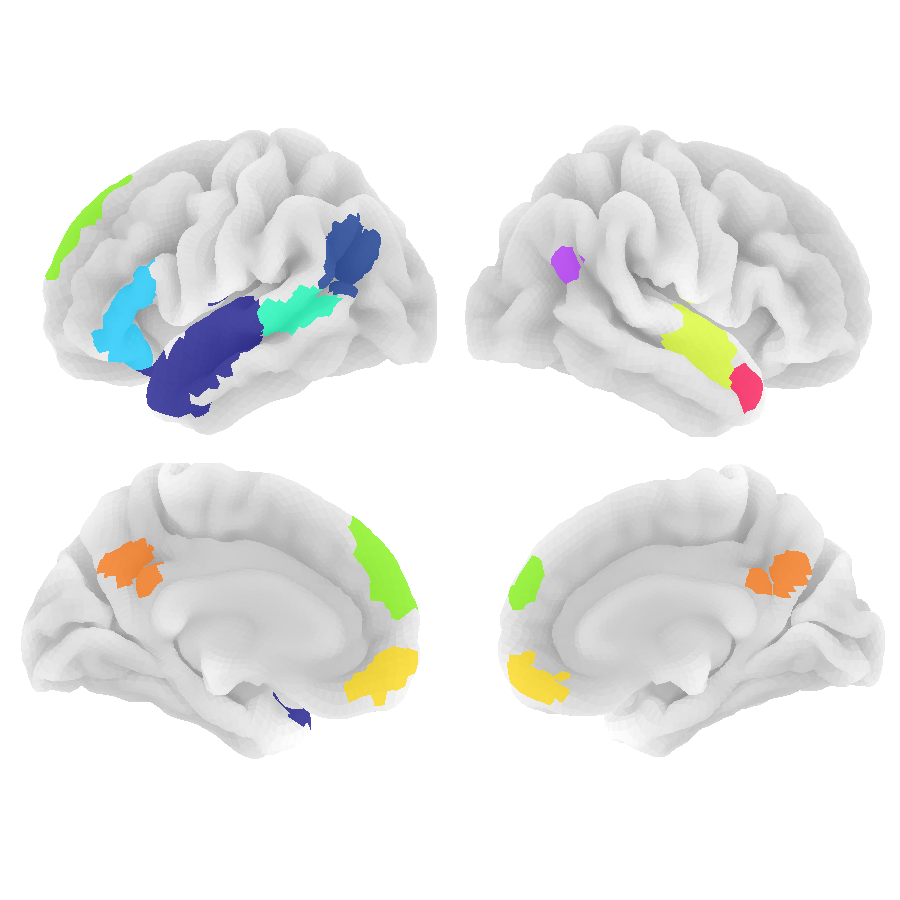

In [4]:
plot_surf(parcels, views=["lateral", "medial"], hemispheres=["left", "right"])

Empirically, we know that smaller parcels are often non-robust, meaning that they might be an artifact of an insufficiently large number of participants. We can filter the parcels by size:

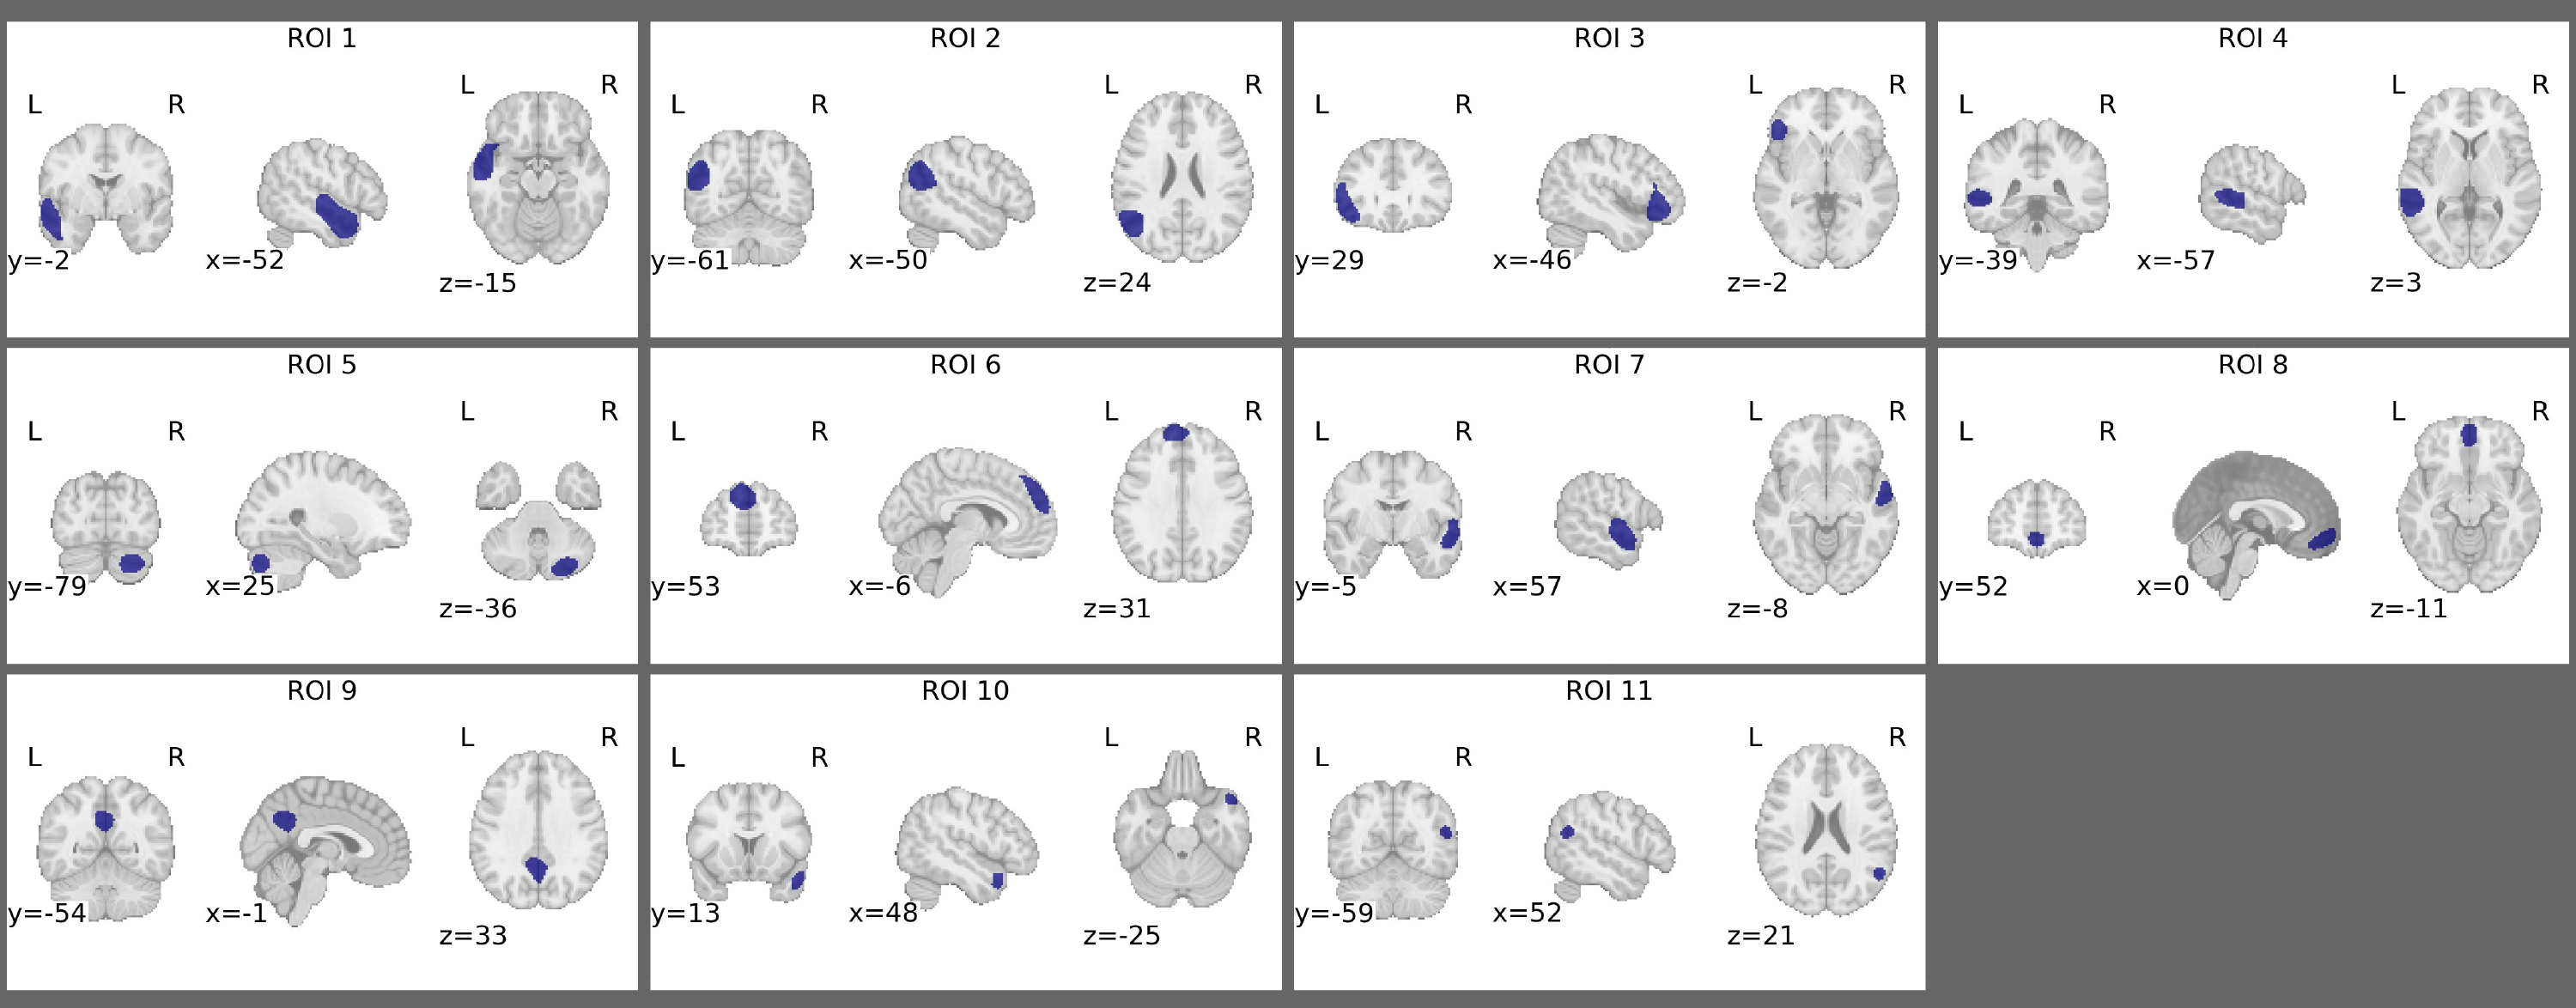

In [19]:
parcels = parcels_generator.filter(min_voxel_size=100)

for froi in np.unique(parcels.get_fdata()):
    if froi == 0: continue
    img_froi = new_img_like(parcels, parcels.get_fdata() == froi)
    fig = plt.figure(figsize=(4,2))
    plot_roi(img_froi, display_mode='ortho', draw_cross=False, figure=fig)
    fig.suptitle(f"ROI {int(froi)}")

Other toolbox options include filtering by % of subjects that show significant activation in that parcel.

## Define Language fROIs for Individual Subjects

For each parcel generated in the previous step, we now define subject-specific functional regions of interest (fROIs) for the language system. Within each parcel, the language fROI for a subject is defined as the top 10% of voxels that exhibit the strongest story-math contrast.

If you proceed directly to the analyses with fROI definition configuration provided, the subject fROIs are automatically defined and saved in the BIDS derivatives. You can customize the definition of the fROI by specifying the proportion of the parcel size (e.g., 10%), a fixed number of voxels, or a significance threshold with respect to a given p-value. The following example demonstrates how to manually generate and inspect fROIs.

Let’s inspect the first three subjects in sample 2 to look at their language fROIs:

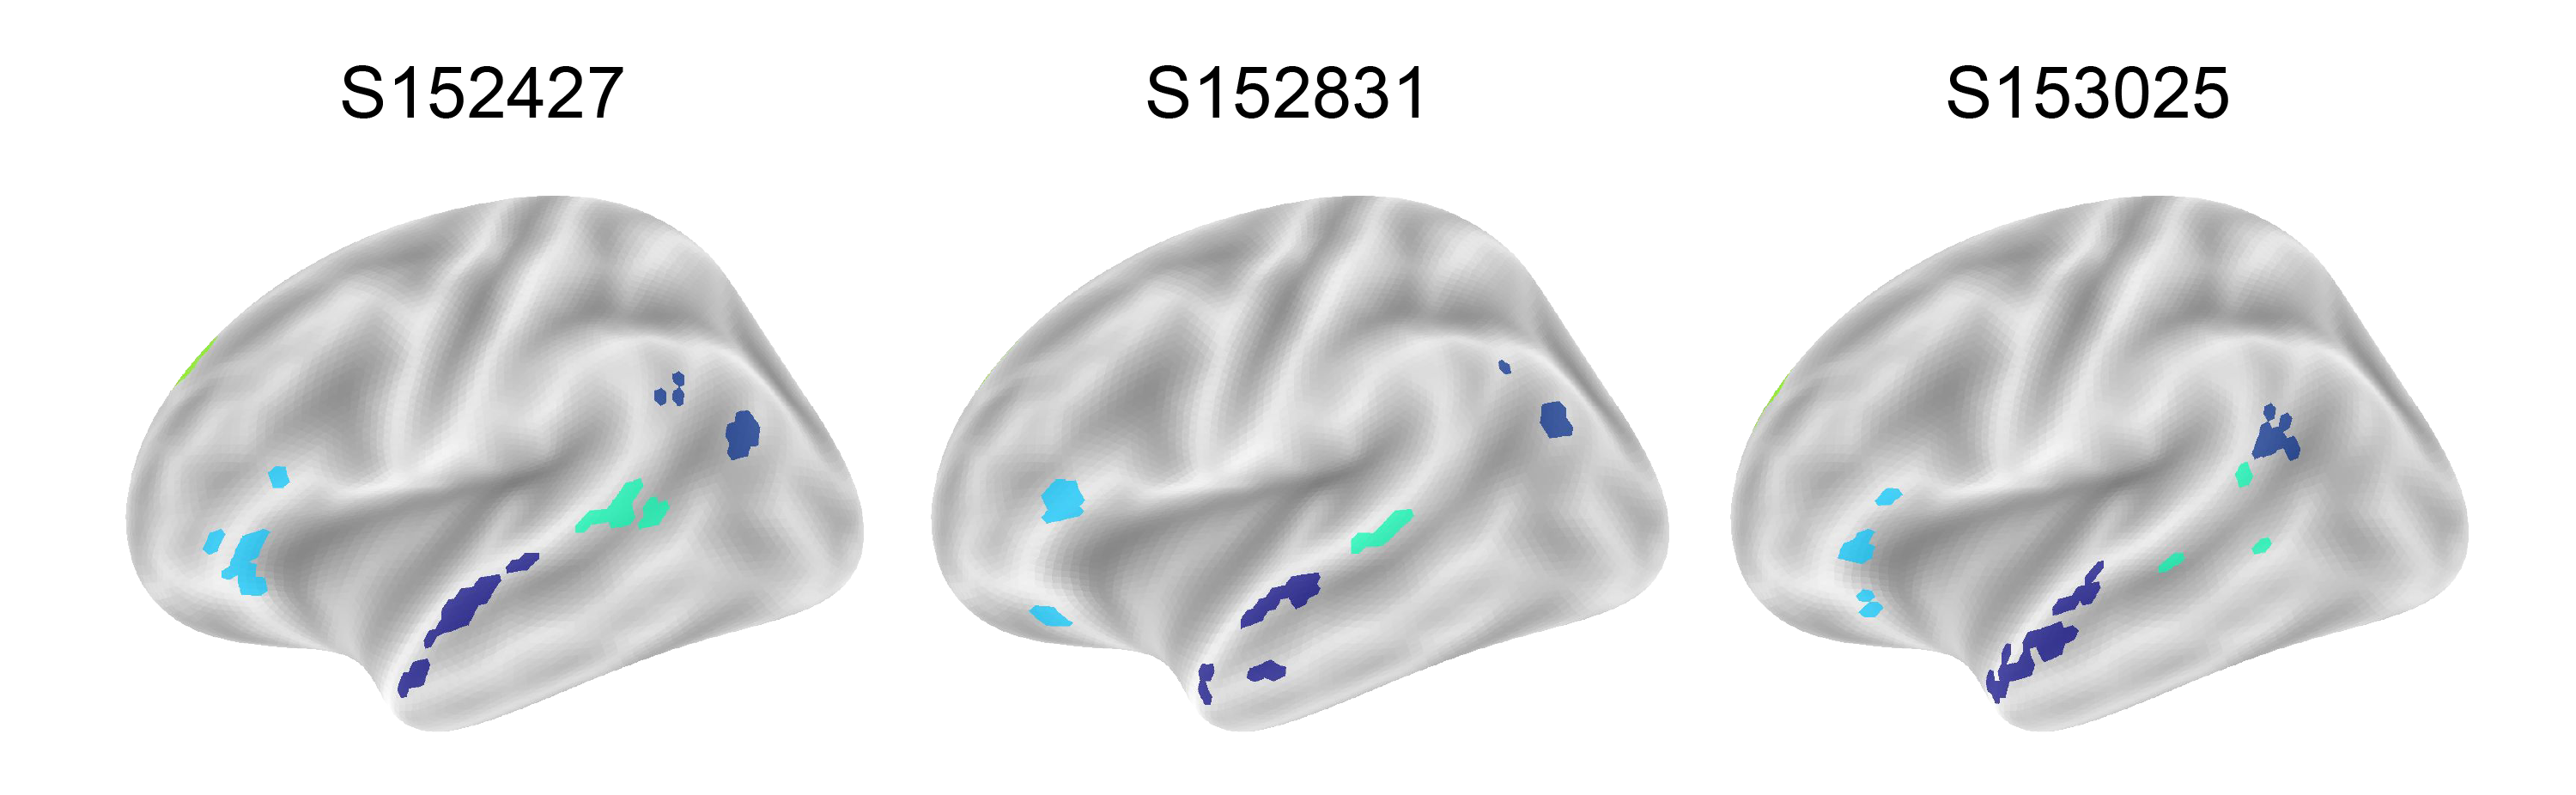

In [6]:
from funROI.analysis import FROIGenerator
froi = funROI.FROIConfig(
    task="LANGUAGE",
    contrasts=["story-math"],
    threshold_type="percent",
    threshold_value=0.1,
    parcels=funROI.ParcelsConfig.from_analysis_output(
        "Language",
        smoothing_kernel_size=10,
        overlap_thr_vox=0.2,
        overlap_thr_roi=0, 
        min_voxel_size=100
    )
)
froi_generator = FROIGenerator(subjects2[:3], froi)
froi_imgs = froi_generator.run()
for subject_label, froi_img in froi_imgs:
    plot_surf(froi_img, views=["lateral"], hemispheres=["left"], inflate=True)

## Analysis: Effect Sizes

Effect size estimation is a critical step in fROI analysis, as it provides a quantitative measure of the strength of the neural response to specific contrasts or conditions.

In this section, we will demonstrate how to estimate effect sizes for story and math conditions within subjects’ language fROIs. The effect sizes of the language system will be evaluated in the fROIs defined in the previous section. Separate fMRI runs are used to define the fROIs and to estimate effect sizes, to avoid double dipping.

We are using the 20-subject independent sample, separate from the set of subjects that we used to define the parcels (as described previously). Here and in later plots, each dot represents a subject.


In [ ]:
from funROI.analysis import EffectEstimator
effect_estimator = EffectEstimator(subjects=subjects2, froi=froi)
df_summary, df_detail = effect_estimator.run(
    task="LANGUAGE", effects=["story", "math"])

As we examine the effect sizes for the subjects' language system, we observe the expected higher responses to story compared to math. This confirms the validity of our approach.

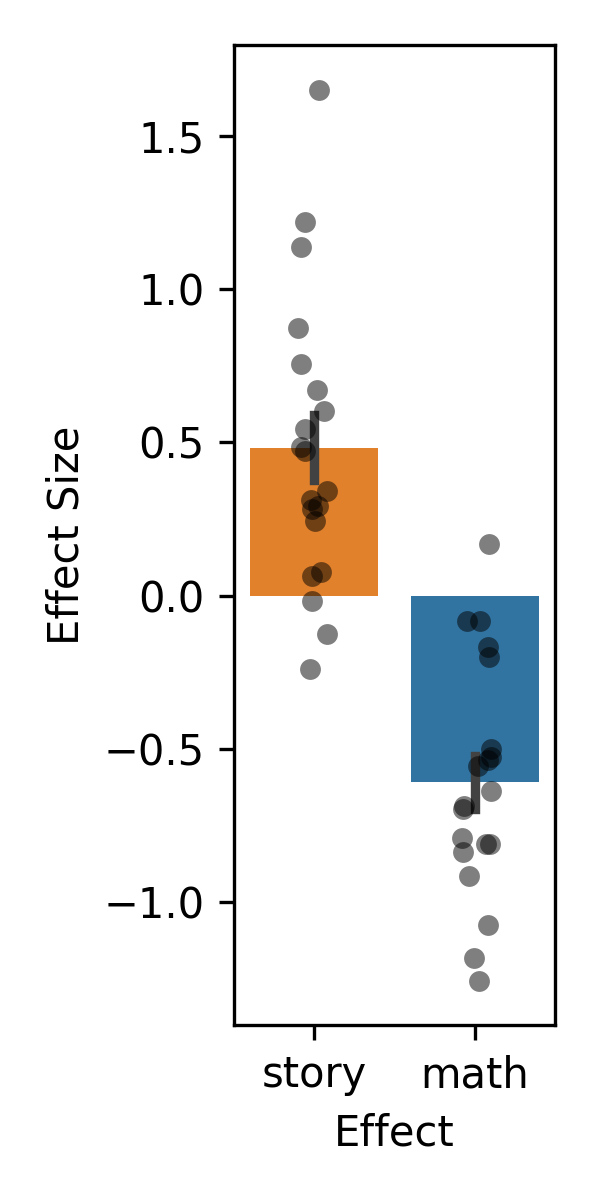

In [15]:
plt.figure(figsize=(2,4), tight_layout=True)
data = df_summary.groupby(["subject", "effect"]).mean().reset_index()
sns.barplot(data=data, y="size", x="effect", hue="effect", errorbar="se", 
            order=["story", "math"])
sns.stripplot(data=data, y="size", x="effect", dodge=False, alpha=0.5, 
              jitter=True, order=["story", "math"], color='black')
plt.ylabel("Effect Size")
plt.xlabel("Effect")

We can also examine the effect sizes by hemisphere. As expected, left hemisphere shows higher responses to language:


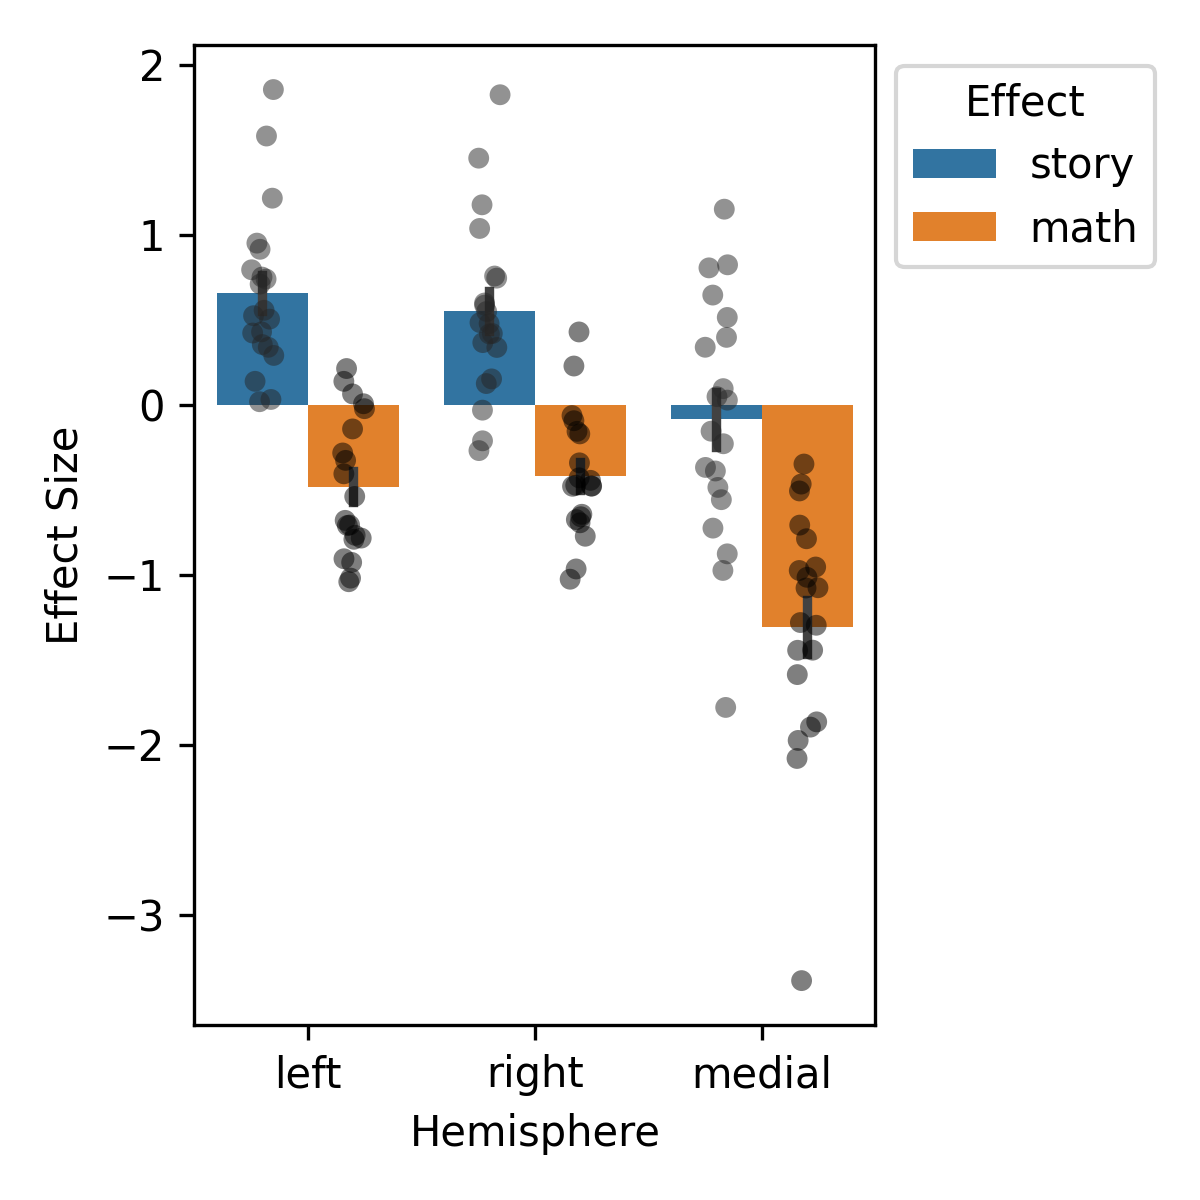

In [17]:
left_rois = [1, 2, 3, 4, 6]
right_rois = [5, 7, 10, 11]
medial_rois = [8, 9, 12]
df_summary['hemisphere'] = df_summary['froi'].apply(
    lambda x: 'left' if x in left_rois 
    else ('right' if x in right_rois else 'medial')
)

plt.figure(figsize=(4, 4), tight_layout=True)
data = df_summary.groupby(["subject", "hemisphere", "effect"]).mean().reset_index()
sns.barplot(data=data, y="size", x="hemisphere", hue="effect", errorbar="se",
           hue_order=["story", "math"], order=["left", "right", "medial"])
sns.stripplot(data=data, y="size", x="hemisphere", hue="effect", dodge=True, 
              alpha=0.5, jitter=True, hue_order=["story", "math"], color='black', 
              legend=False, order=["left", "right", "medial"])
plt.ylabel("Effect Size")
plt.xlabel("Hemisphere")
plt.legend(loc='upper left', title='Effect', bbox_to_anchor=(1, 1))

Finally, we can examine responses in individual fROIs. We see substantial heterogeneity in response magnitudes to each task, due likely to a combination of physiological and cognitive factors:


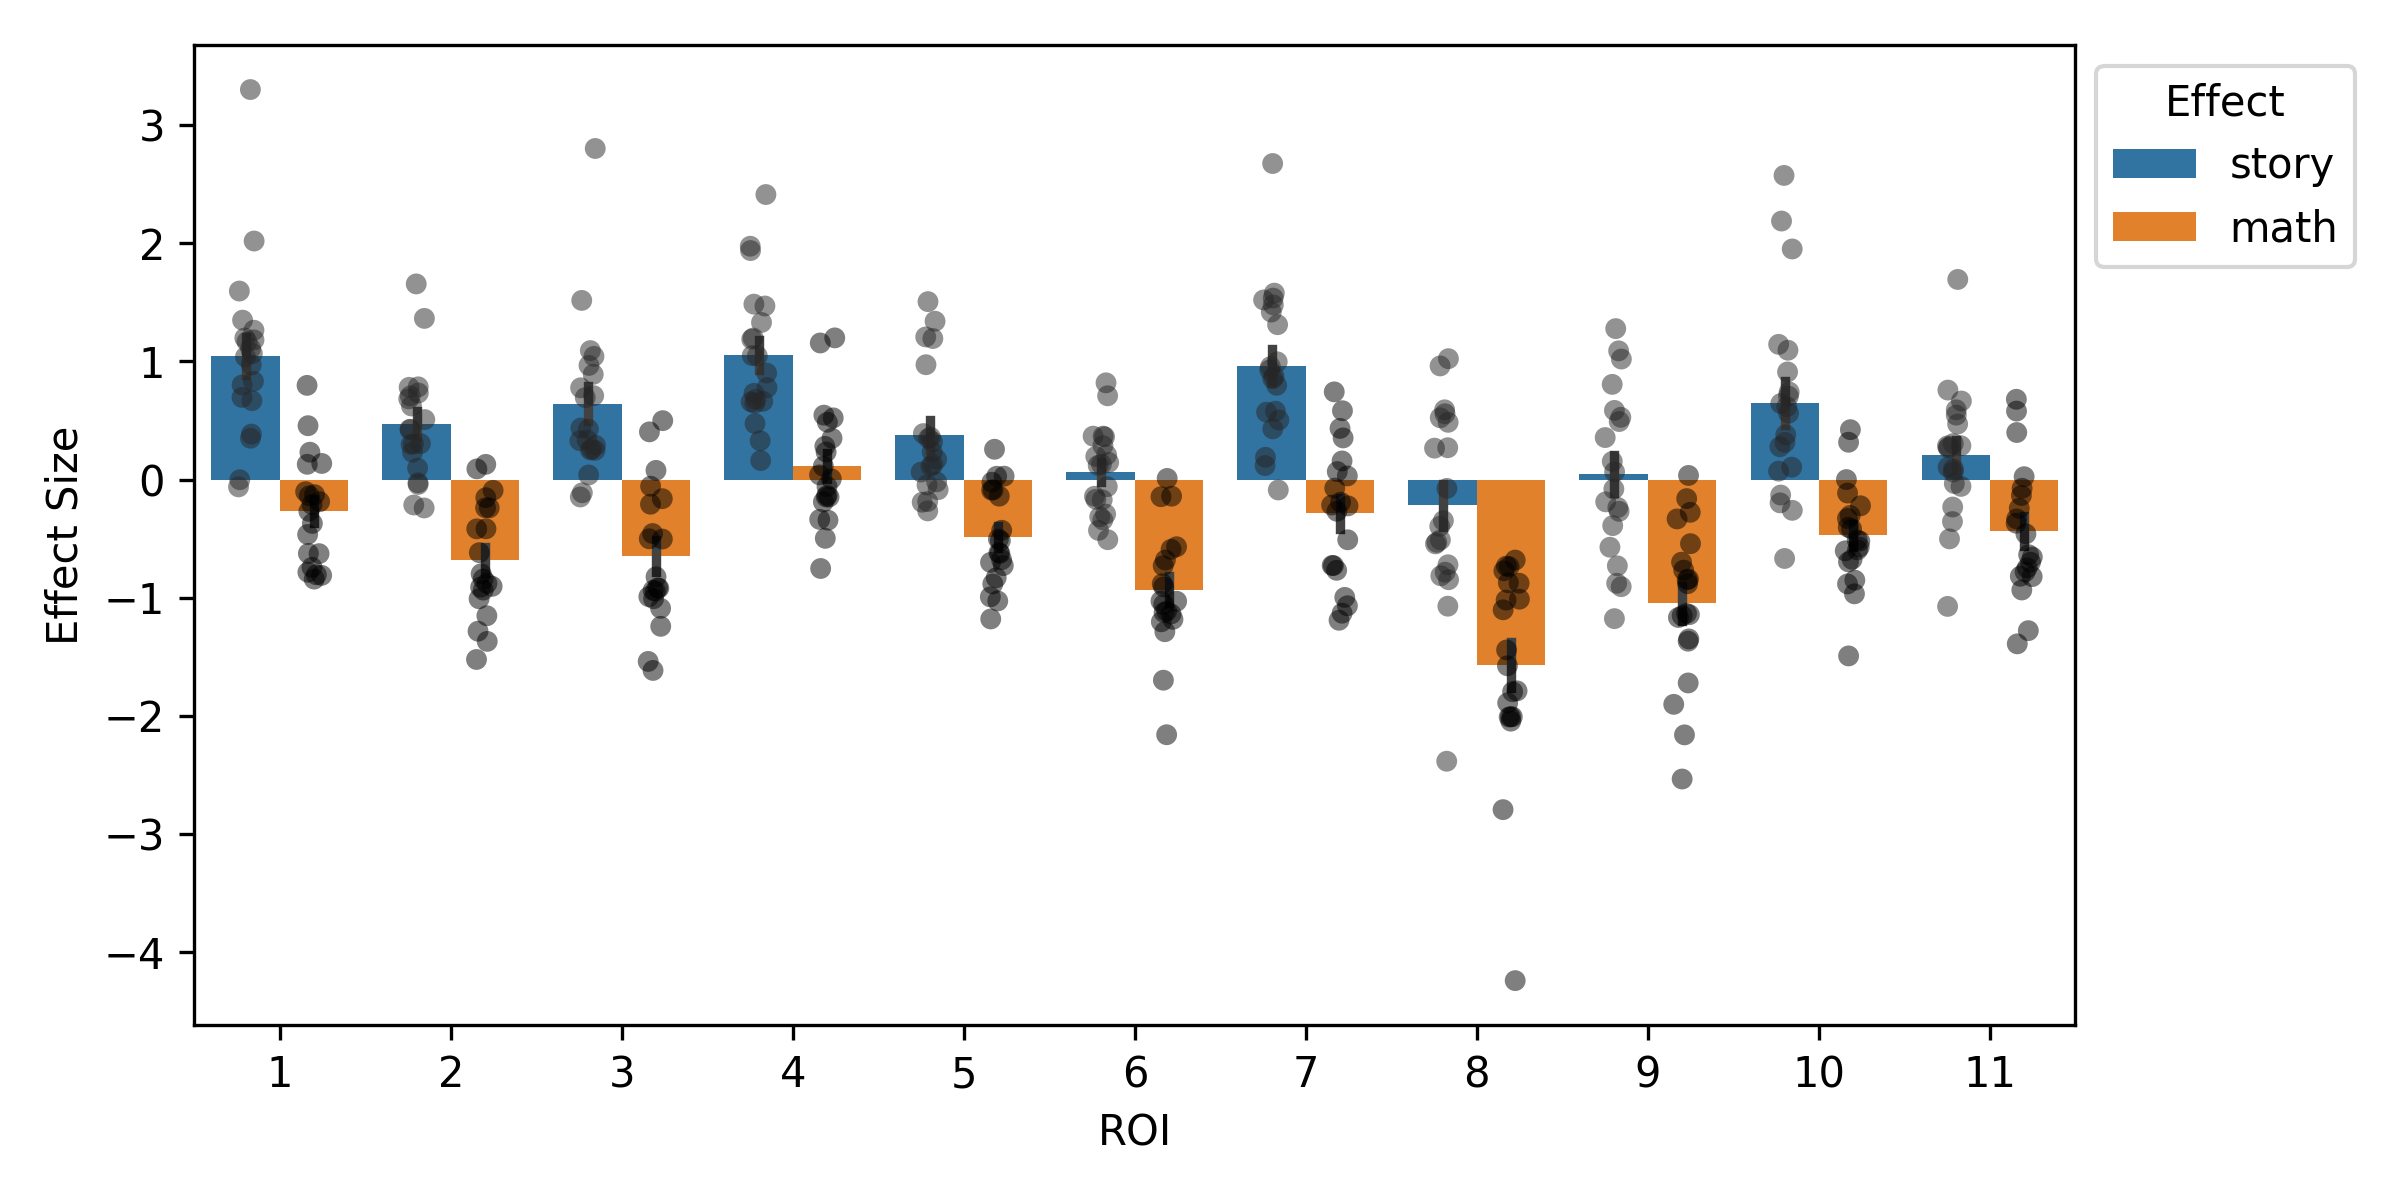

In [23]:
plt.figure(figsize=(8, 4), tight_layout=True)
sns.barplot(data=df_summary, y="size", x="froi", hue="effect", errorbar="se",
           hue_order=["story", "math"])
sns.stripplot(data=df_summary, y="size", x="froi", hue="effect", dodge=True, 
              alpha=0.5, jitter=True, hue_order=["story", "math"], 
              color='black', legend=False)
plt.ylabel("Effect Size")
plt.xlabel("ROI")
plt.legend(loc='upper left', title='Effect', bbox_to_anchor=(1, 1))

Note that, in this example, the heterogeneity we observe is largely due to the fact that the HCP language localizer is very imprecise. A story>math contrast includes many different cognitive processes other than language (e.g., situation modeling to accurately track a narrative and social reasoning to interpret the characters’ intent). Thus, not all fROIs are language-specific (which is something we can test by estimating these fROIs’ responses to other conditions and tasks).


## Analysis: Spatial Correlation Across Conditions

Spatial correlation provides a valuable metric for assessing the similarity of within-subject activation patterns across different conditions or runs, allowing researchers to evaluate the consistency of functional responses in specific regions of the brain. This analysis can be performed on either parcels or fROIs.

Here, we will estimate the spatial correlation between the story and math conditions within each language parcel (using the parcels defined in the “Generate Parcels for the Language System” section). 


In [ ]:
from funROI.analysis import SpatialCorrelationEstimator
spcorr_estimator = SpatialCorrelationEstimator(
    subjects=subjects2,
    froi=funROI.ParcelsConfig.from_analysis_output(
        "Language",
        smoothing_kernel_size=10,
        overlap_thr_vox=0.2,
        overlap_thr_roi=0, 
        min_voxel_size=100
    )
)
df_math, _ = spcorr_estimator.run(
    task1='LANGUAGE', effect1='math', task2='LANGUAGE', effect2='math',
)
df_story, _ = spcorr_estimator.run(
    task1='LANGUAGE', effect1='story', task2='LANGUAGE', effect2='story',
)
df_between, _ = spcorr_estimator.run(
    task1='LANGUAGE', effect1='story', task2='LANGUAGE', effect2='math',
)

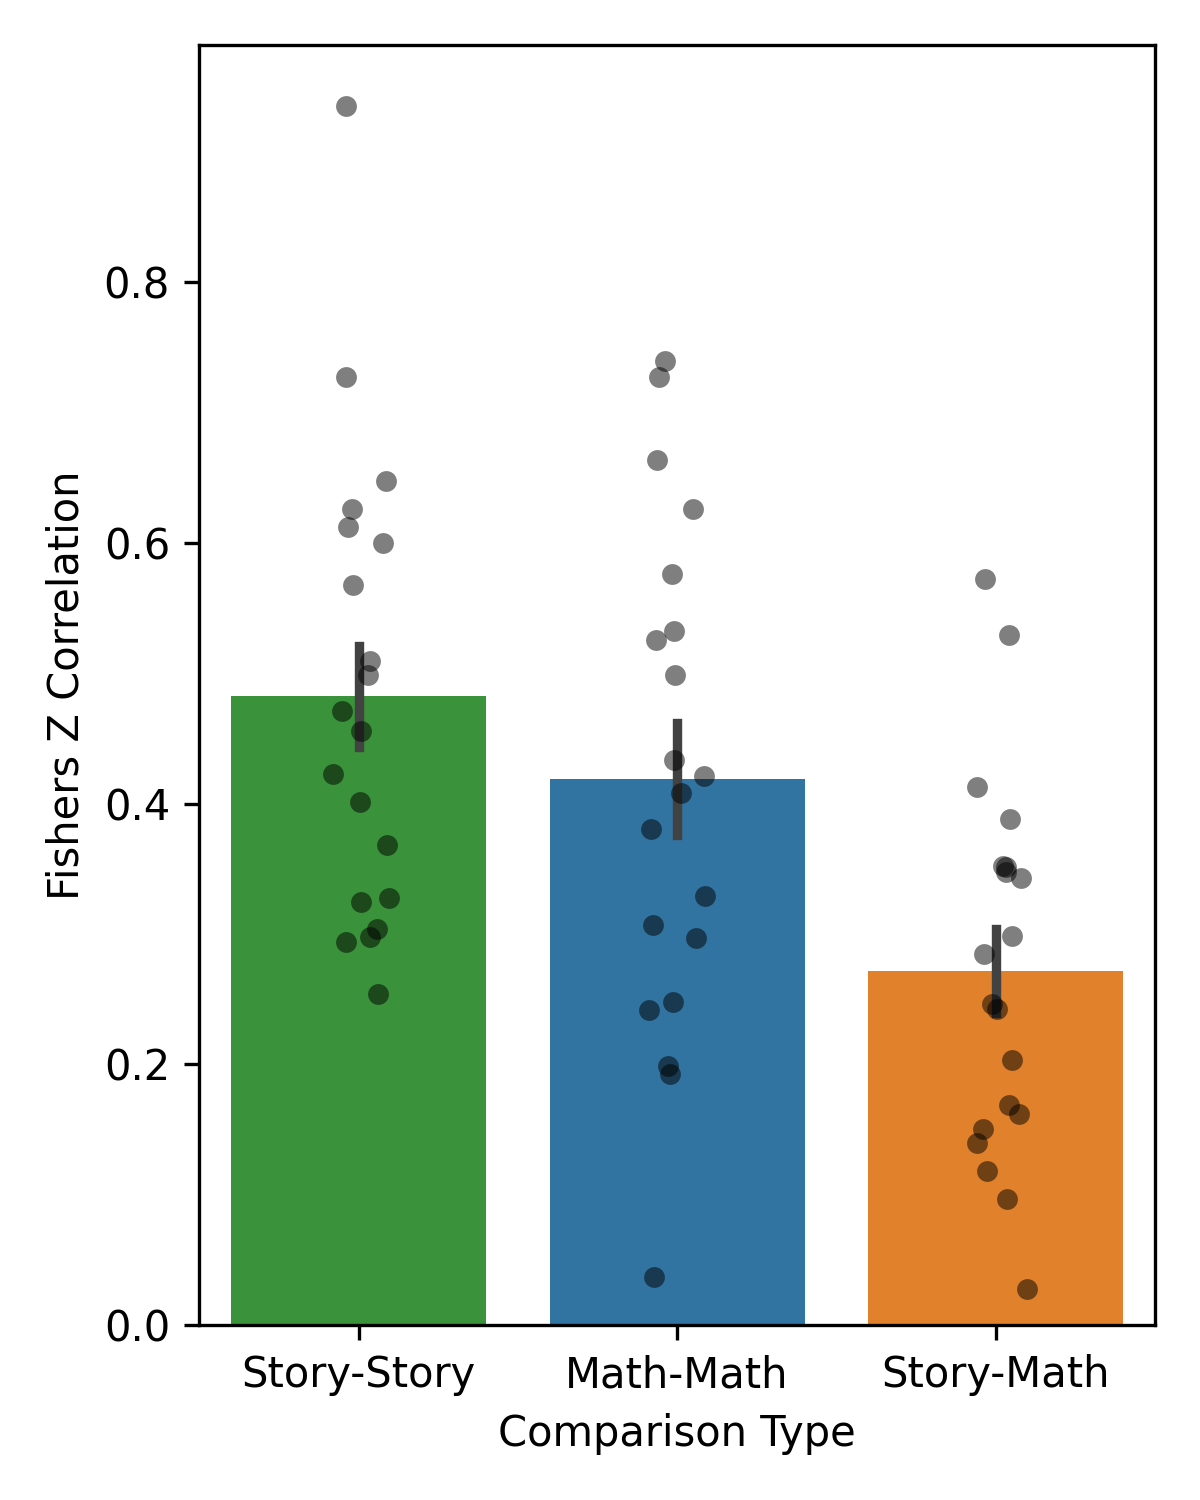

In [22]:
df_math['Type'] = 'Math-Math'
df_story['Type'] = 'Story-Story'
df_between['Type'] = 'Story-Math'
data = pd.concat(
    [df_between, df_math, df_story]
).groupby(["subject", "Type"]).mean().reset_index()

plt.figure(figsize=(4,5))
sns.barplot(data=data, y="fisher_z", x="Type", hue="Type", errorbar="se", 
            order=["Story-Story",  "Math-Math", "Story-Math"])
sns.stripplot(data=data, y="fisher_z", x="Type", dodge=False, alpha=0.5, 
              jitter=True, order=["Story-Story",  "Math-Math", "Story-Math"], 
              color='black')
plt.ylabel("Fishers Z Correlation")
plt.xlabel("Comparison Type")

## Analysis: Overlap Between fROIs

Assessing the spatial overlap between parcels or fROIs can be useful in various ways, guiding comparisons across tasks and conditions. In this section, we showcase an example of computing the degree of overlap between the language system defined using the localizer, as stated above (10% top voxels), across subjects and within subjects using different runs.

We support two overlap measurements: [Dice coefficient](https://en.wikipedia.org/wiki/Dice-S%C3%B8rensen_coefficient) and [overlap coefficient](https://en.wikipedia.org/wiki/Overlap_coefficient). The default is the overlap coefficient, which is what we will use now.

In [ ]:
from funROI.analysis import OverlapEstimator
overlap_estimator = OverlapEstimator()
data = []
for i, subject1 in enumerate(subjects2):
    df, _ = overlap_estimator.run(
        froi1=froi, froi2=froi, subject1=subject1, subject2=subject1, 
        run1='01', run2='02'
    )
    data.append(df[df['froi1'] == df['froi2']])

    subject2 = subjects2[(i+1) % len(subjects2)]
    df, _ = overlap_estimator.run(
        froi1=froi, froi2=froi, subject1=subject1, subject2=subject2, 
        run1='01', run2='02'
    )
    data.append(df[df['froi1'] == df['froi2']])

data = pd.concat(data)

The results visualized below illustrate the spatial overlap results:

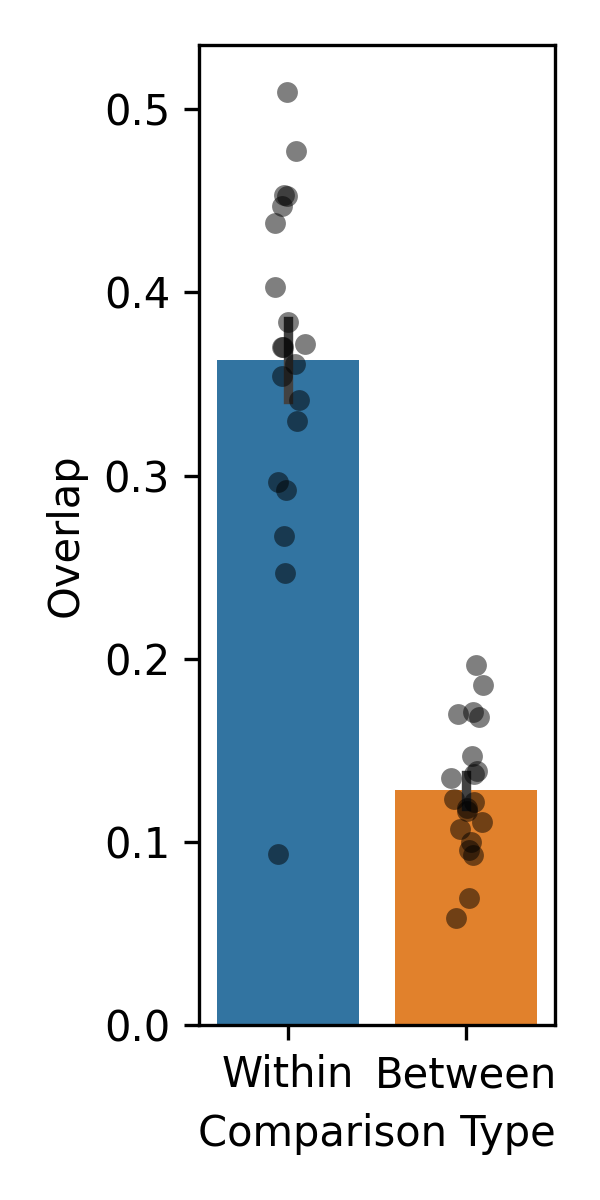

In [25]:
data.loc[data['subject1'] == data['subject2'], 'Type'] = 'Within'
data.loc[data['subject1'] != data['subject2'], 'Type'] = 'Between'
data_mean = data.groupby(["subject1", "subject2", "Type"]).mean().reset_index()
plt.figure(figsize=(2,4), tight_layout=True)
sns.barplot(data=data_mean, y="overlap", x="Type", hue="Type", errorbar="se")
sns.stripplot(data=data_mean, y="overlap", x="Type", dodge=False, 
              alpha=0.5, jitter=True, color='black')
plt.ylabel("Overlap")
plt.xlabel("Comparison Type")

They demonstrate that the fROIs from the same subject (defined using different sets of data) are more consistent compared to fROIs from different subjects, a result that motivates the entire subject-specific fROI approach to fMRI analyses. 

Let's see some example fROIs by leveraging the fROI generator:  

- Two brains in the same row: fROI defined for the same subject across different runs.

- Two brains in the same column: fROIs defined for different subjects.

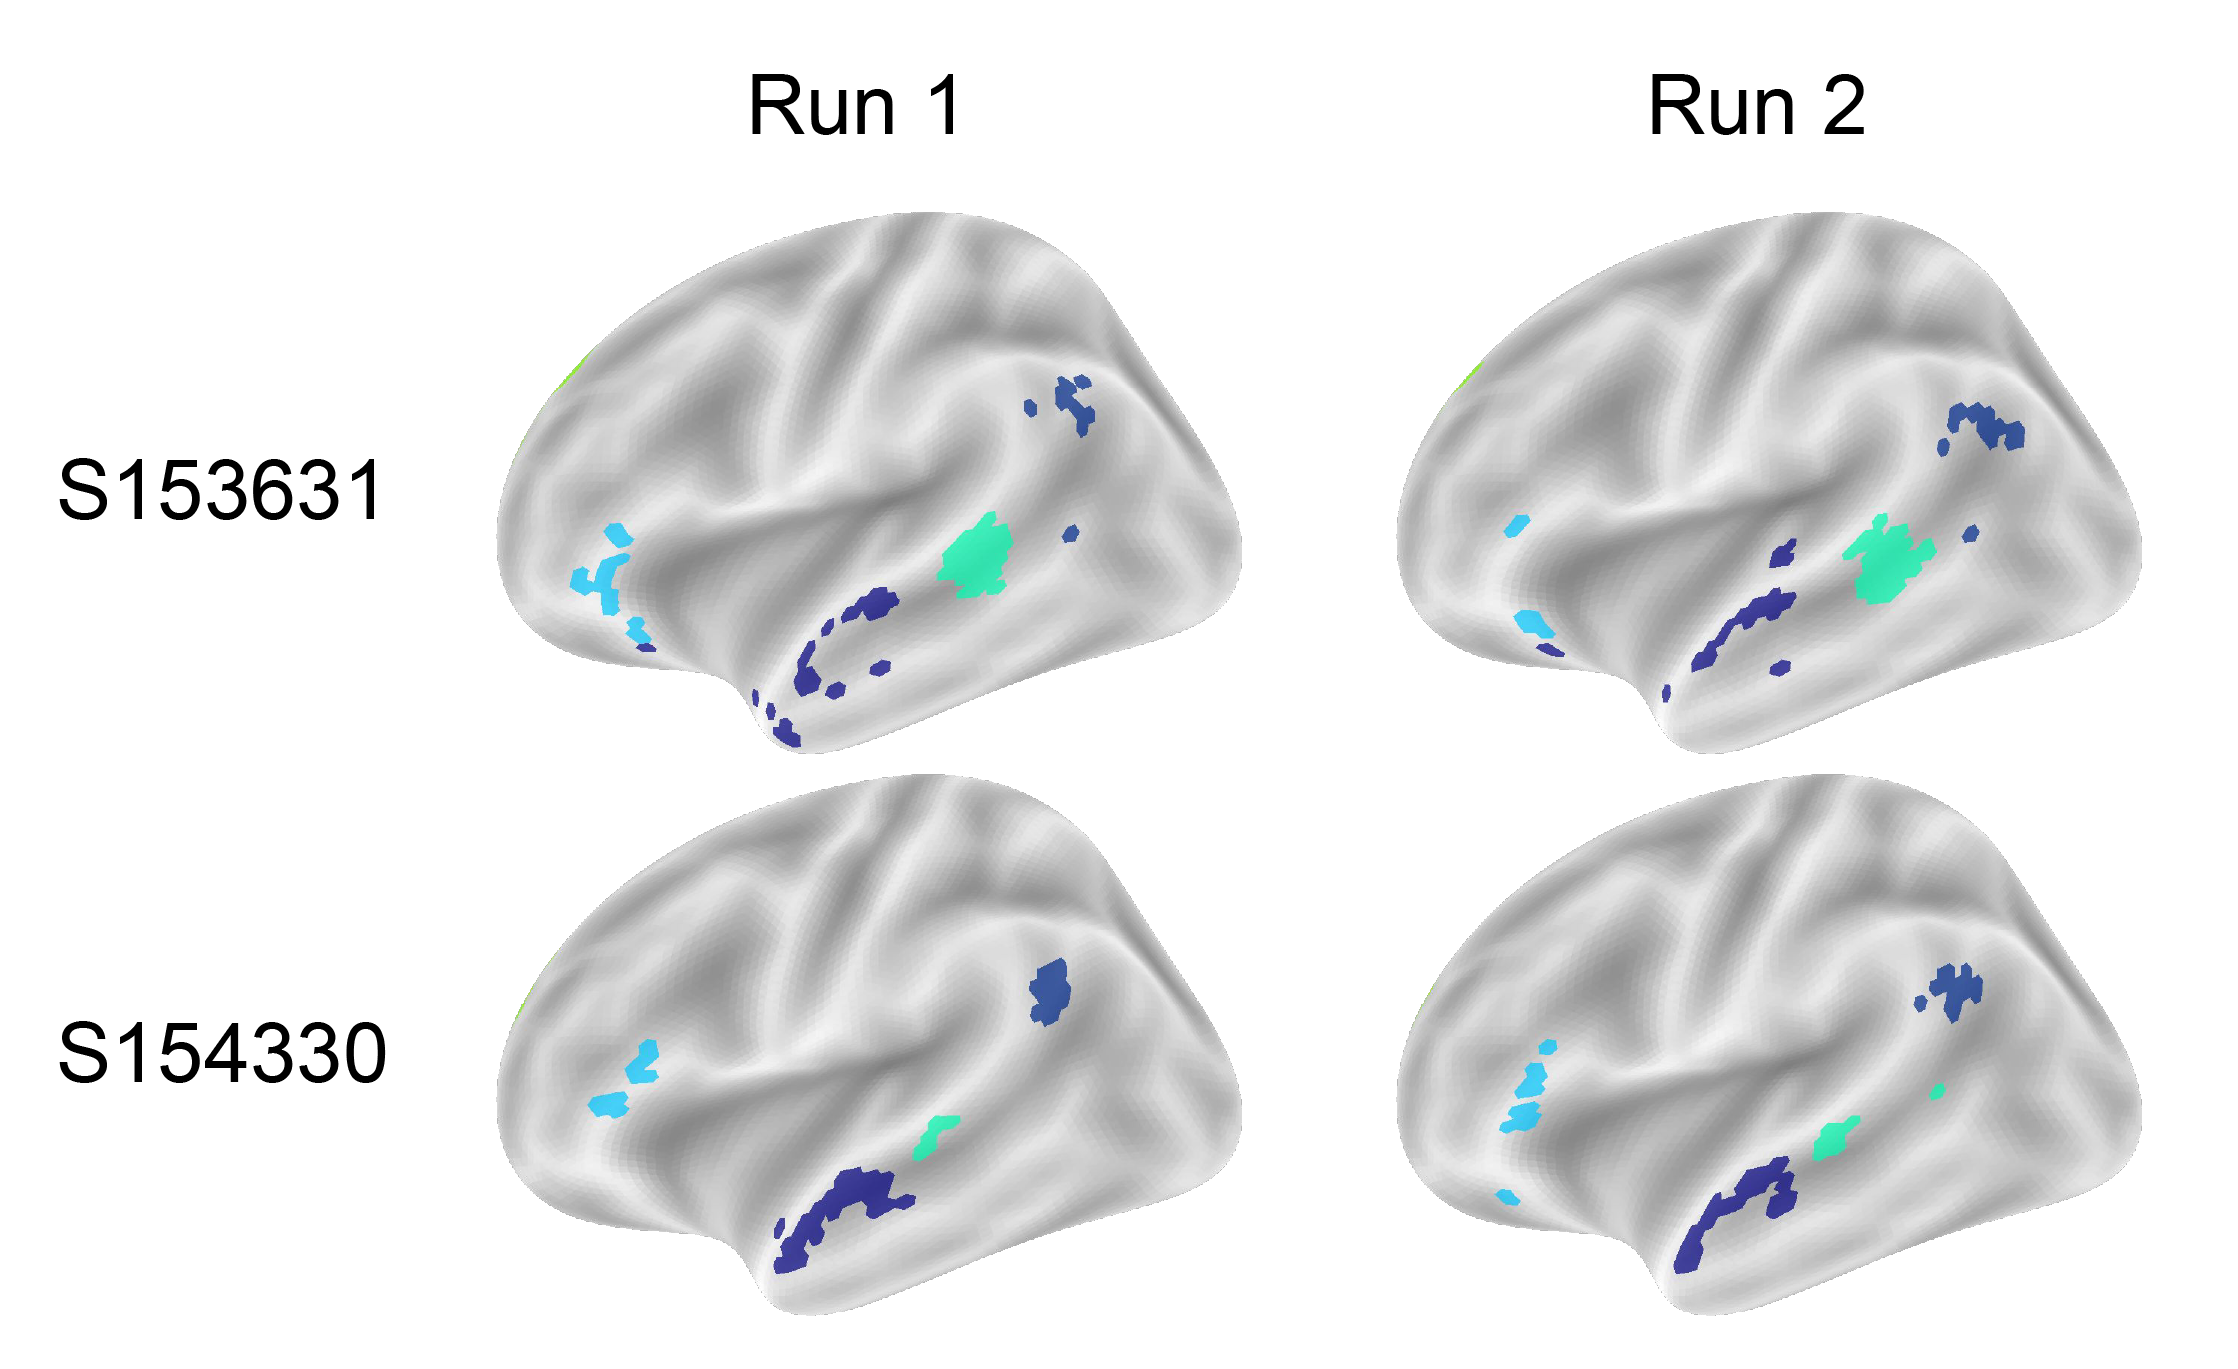

In [27]:
from funROI.analysis import FROIGenerator
for subject, run in zip(['153631', '153631', '154330', '154330'], 
                        ['01', '02', '01', '02']):
    froi_generator = ([subject], froi, run_label=run)
    froi_imgs = froi_generator.run()
    subject_label, froi_img = froi_imgs[0]
    plot_surf(froi_img, views=["lateral"], hemispheres=["left"], inflate=True)

In this demo, we showcased a complete workflow for analyzing the language system in the HCP dataset, starting with first-level modeling and culminating in subject-specific fROI definitions derived from the story>math contrast. By constructing probabilistic maps, generating parcels, and selecting subject-specific peak activation voxels within these parcels, we demonstrated how to obtain robust measures of functional responses. We then evaluated fROIs through a series of analyses—effect size estimation, spatial correlation, and overlap assessment—showing that subject-specific fROIs exhibit a higher degree of consistency compared to group-level approaches. Overall, this pipeline highlights the benefits of a tailored fROI approach for capturing individual differences in language-related brain activity.